This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Beam Blockage Calculation using a DEM

Here, we derive (**p**artial) **b**eam-**b**lockage (**PBB**) from a **D**igital **E**levation **M**odel (**DEM**). 

We require
- the local radar setup (sitecoords, number of rays, number of bins, antenna elevation, beamwidth, and the range resolution);
- a **DEM** with a adequate resolution. 

Here we use pre-processed data from the [GTOPO30](https://lta.cr.usgs.gov/GTOPO30) and [SRTM](https://www2.jpl.nasa.gov/srtm/) missions.

In [1]:
import wradlib as wrl
import matplotlib.pyplot as pl
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np

## Setup for Bonn radar

First, we need to define some radar specifications (here: *University of Bonn*).

In [2]:
sitecoords = (7.071663, 50.73052, 99.5)
nrays = 360 # number of rays
nbins = 1000 # number of range bins
el = 1.0 # vertical antenna pointing angle (deg)
bw = 1.0 # half power beam width (deg)
range_res = 100. # range resolution (meters)

Create the range, azimuth, and beamradius arrays.

In [3]:
r = np.arange(nbins) * range_res
beamradius = wrl.util.half_power_radius(r, bw)

We use 

- [wradlib.georef.sweep_centroids](https://docs.wradlib.org/en/latest/generated/wradlib.georef.polar.sweep_centroids.html)  and 
- [wradlib.georef.spherical_to_proj](https://docs.wradlib.org/en/latest/generated/wradlib.georef.polar.spherical_to_proj.html) 

to calculate the spherical coordinates of the bin centroids and their longitude, latitude and altitude.

In [4]:
coord = wrl.georef.sweep_centroids(nrays, range_res, nbins, el)
coords = wrl.georef.spherical_to_proj(coord[..., 0], 
                                      np.degrees(coord[..., 1]),
                                      coord[..., 2], sitecoords)
lon = coords[..., 0]
lat = coords[..., 1]
alt = coords[..., 2]

In [5]:
polcoords = coords[..., :2]
print("lon,lat,alt:", coords.shape)

lon,lat,alt: (360, 1000, 3)


In [6]:
rlimits = (lon.min(), lat.min(), lon.max(), lat.max())
print("Radar bounding box:\n\t%.2f\n%.2f             %.2f\n\t%.2f" % 
      (lat.max(), lon.min(), lon.max(), lat.min()))

Radar bounding box:
	51.63
5.66             8.49
	49.83


## Preprocessing the digitial elevation model

- Read the DEM from a ``geotiff`` file (in `WRADLIB_DATA`);
- clip the region inside the bounding box;
- map the DEM values to the polar grid points. 

*Note*: You can choose between the coarser resolution `bonn_gtopo.tif` (from GTOPO30) and the finer resolution `bonn_new.tif` (from the SRTM mission).

The DEM raster data is opened via [wradlib.io.open_raster](https://docs.wradlib.org/en/latest/generated/wradlib.io.gdal.open_raster.html) and extracted via [wradlib.georef.extract_raster_dataset](https://docs.wradlib.org/en/latest/generated/wradlib.georef.raster.extract_raster_dataset.html).

In [7]:
#rasterfile = wrl.util.get_wradlib_data_file('geo/bonn_gtopo.tif')
rasterfile = wrl.util.get_wradlib_data_file('geo/bonn_new.tif')

ds = wrl.io.open_raster(rasterfile)
rastervalues, rastercoords, proj = wrl.georef.extract_raster_dataset(ds, nodata=-32768.)

# Clip the region inside our bounding box 
ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
rastercoords = rastercoords[ind[1]:ind[3], ind[0]:ind[2], ...]
rastervalues = rastervalues[ind[1]:ind[3], ind[0]:ind[2]]

# Map rastervalues to polar grid points
polarvalues = wrl.ipol.cart_to_irregular_spline(rastercoords, rastervalues,
                                             polcoords, order=3,
                                             prefilter=False)

## Calculate Beam-Blockage

Now we can finally apply the [wradlib.qual.beam_block_frac](https://docs.wradlib.org/en/latest/generated/wradlib.qual.beam_block_frac.html) function to calculate the PBB.

In [8]:
PBB = wrl.qual.beam_block_frac(polarvalues, alt, beamradius)
PBB = np.ma.masked_invalid(PBB)
print(PBB.shape)

(360, 1000)


So far, we calculated the fraction of beam blockage for each bin.

But we need to into account that the radar signal travels along a beam. Cumulative beam blockage (CBB) in one bin along a beam will always be at least as high as the maximum PBB of the preceeding bins (see [wradlib.qual.cum_beam_block_frac](https://docs.wradlib.org/en/latest/generated/wradlib.qual.cum_beam_block_frac.html))

In [9]:
CBB = wrl.qual.cum_beam_block_frac(PBB)
print(CBB.shape)

(360, 1000)


## Visualize Beamblockage

Now we visualize
- the average terrain altitude per radar bin
- a beam blockage map
- interaction with terrain along a single beam

In [10]:
# just a little helper function to style x and y axes of our maps
def annotate_map(ax, cm=None, title=""):
    ticks = (ax.get_xticks()/1000).astype(np.int)
    ax.set_xticklabels(ticks)
    ticks = (ax.get_yticks()/1000).astype(np.int)
    ax.set_yticklabels(ticks)
    ax.set_xlabel("Kilometers")
    ax.set_ylabel("Kilometers")
    if not cm is None:
        pl.colorbar(cm, ax=ax)
    if not title=="":
        ax.set_title(title)
    ax.grid()

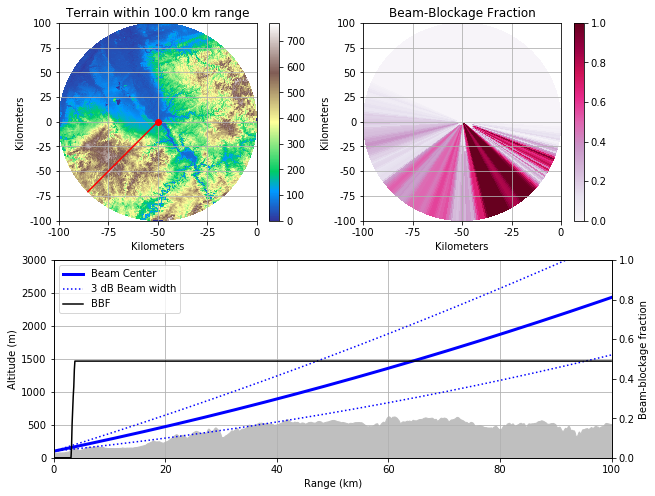

In [11]:
fig = pl.figure(figsize=(10, 8))

# create subplots
ax1 = pl.subplot2grid((2, 2), (0, 0))
ax2 = pl.subplot2grid((2, 2), (0, 1))
ax3 = pl.subplot2grid((2, 2), (1, 0), colspan=2, rowspan=1)

# azimuth angle
angle = 225

# Plot terrain (on ax1)
ax1, dem = wrl.vis.plot_ppi(polarvalues, 
                            ax=ax1, r=r, 
                            az=np.degrees(coord[:,0,1]), 
                            cmap=mpl.cm.terrain, vmin=0.)
ax1.plot([0,np.sin(np.radians(angle))*1e5],
         [0,np.cos(np.radians(angle))*1e5],"r-")
ax1.plot(sitecoords[0], sitecoords[1], 'ro')
annotate_map(ax1, dem, 'Terrain within {0} km range'.format(np.max(r / 1000.) + 0.1))

# Plot CBB (on ax2)
ax2, cbb = wrl.vis.plot_ppi(CBB, ax=ax2, r=r, 
                            az=np.degrees(coord[:,0,1]),
                            cmap=mpl.cm.PuRd, vmin=0, vmax=1)
annotate_map(ax2, cbb, 'Beam-Blockage Fraction')

# Plot single ray terrain profile on ax3
bc, = ax3.plot(r / 1000., alt[angle, :], '-b',
               linewidth=3, label='Beam Center')
b3db, = ax3.plot(r / 1000., (alt[angle, :] + beamradius), ':b',
                 linewidth=1.5, label='3 dB Beam width')
ax3.plot(r / 1000., (alt[angle, :] - beamradius), ':b')
ax3.fill_between(r / 1000., 0.,
                 polarvalues[angle, :],
                 color='0.75')
ax3.set_xlim(0., np.max(r / 1000.) + 0.1)
ax3.set_ylim(0., 3000)
ax3.set_xlabel('Range (km)')
ax3.set_ylabel('Altitude (m)')
ax3.grid()

axb = ax3.twinx()
bbf, = axb.plot(r / 1000., CBB[angle, :], '-k',
                label='BBF')
axb.set_ylabel('Beam-blockage fraction')
axb.set_ylim(0., 1.)
axb.set_xlim(0., np.max(r / 1000.) + 0.1)


legend = ax3.legend((bc, b3db, bbf), 
                    ('Beam Center', '3 dB Beam width', 'BBF'),
                    loc='upper left', fontsize=10)

## Visualize Beam Propagation showing earth curvature

Now we visualize
- interaction with terrain along a single beam

In this representation the earth curvature is shown. For this we assume the earth a sphere with exactly 6370000 m radius. This is needed to get the height ticks at nice position.

In [12]:
def height_formatter(x, pos):
    x = (x - 6370000) / 1000
    fmt_str = '{:g}'.format(x)
    return fmt_str
    
def range_formatter(x, pos):
    x = x / 1000.
    fmt_str = '{:g}'.format(x)
    return fmt_str

- The [wradlib.vis.create_cg](https://docs.wradlib.org/en/latest/generated/wradlib.vis.create_cg.html)-function is facilitated to create the curved geometries. 
- The actual data is plottet as (theta, range) on the parasite axis. 
- Some tweaking is needed to get the final plot look nice.

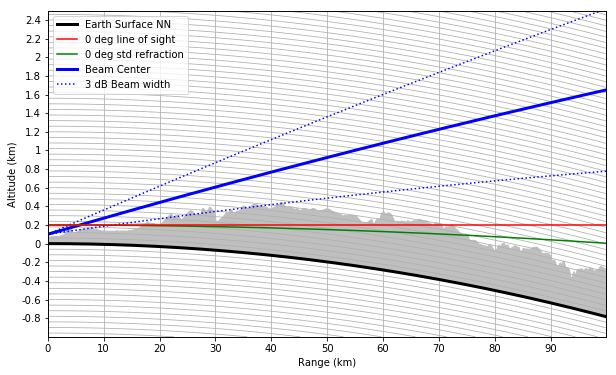

In [13]:
fig = pl.figure(figsize=(10, 6))

cgax, caax, paax = wrl.vis.create_cg(fig=fig, rot=0, scale=1)

# azimuth angle
angle = 225

# fix grid_helper
er = 6370000
gh = cgax.get_grid_helper()
gh.grid_finder.grid_locator2._nbins=80
gh.grid_finder.grid_locator2._steps=[1,2,4,5,10]

# calculate beam_height and arc_distance for ke=1
# means line of sight
bhe = wrl.georef.bin_altitude(r, 0, sitecoords[2], re=er, ke=1.)
ade = wrl.georef.bin_distance(r, 0, sitecoords[2], re=er, ke=1.)
nn0 = np.zeros_like(r)
# for nice plotting we assume earth_radius = 6370000 m
ecp = nn0 + er
# theta (arc_distance sector angle)
thetap = - np.degrees(ade/er) + 90.0

# zero degree elevation with standard refraction
bh0 = wrl.georef.bin_altitude(r, 0, sitecoords[2], re=er)

# plot (ecp is earth surface normal null)
bes, = paax.plot(thetap, ecp, '-k', linewidth=3, label='Earth Surface NN')
bc, = paax.plot(thetap, ecp + alt[angle, :], '-b', linewidth=3, label='Beam Center')
bc0r, = paax.plot(thetap, ecp + bh0 + alt[angle, 0] , '-g', label='0 deg Refraction')
bc0n, = paax.plot(thetap, ecp + bhe + alt[angle, 0], '-r', label='0 deg line of sight')
b3db, = paax.plot(thetap, ecp + alt[angle, :]  + beamradius, ':b', label='+3 dB Beam width')
paax.plot(thetap, ecp + alt[angle, :] - beamradius, ':b', label='-3 dB Beam width')

# orography
paax.fill_between(thetap, ecp,
                  ecp + polarvalues[angle, :],
                  color='0.75')

# shape axes
cgax.set_xlim(0, np.max(ade))
cgax.set_ylim([ecp.min()-1000, ecp.max()+2500])
caax.grid(True, axis='x')
cgax.grid(True, axis='y')
cgax.axis['top'].toggle(all=False)
caax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(steps=[1,2,4,5,10], nbins=20, prune='both'))
caax.xaxis.set_major_locator(mpl.ticker.MaxNLocator())
caax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(height_formatter))
caax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(range_formatter))

caax.set_xlabel('Range (km)')
caax.set_ylabel('Altitude (km)')
    
legend = paax.legend((bes, bc0n, bc0r, bc, b3db), 
                    ('Earth Surface NN', '0 deg line of sight', '0 deg std refraction', 'Beam Center', '3 dB Beam width'),
                    loc='upper left', fontsize=10)

Go back to [Read DEM Raster Data](#Read-DEM-Raster-Data), change the rasterfile to use the other resolution DEM and process again.